# Bart Analysis

Analysis of the open bart dataset

## TODO

* [ ] Sundays versus Weekday + Saturday
* [ ] Fare analysis
  * [x] revenue @ clipper price
  * [ ] revenue @ fixed rate
* [ ] distance between stations (number of stops, miles)
* [ ] analyze commuter versus non-commuter rides by splitting into M-F 7am-6pm & other

In [273]:
import pandas as pd
import time
import altair as alt
import requests
import itertools
import requests_cache

requests_cache.install_cache()

alt.renderers.enable("notebook")

RendererRegistry.enable('notebook')

In [274]:
df = pd.concat(
    [
#         pd.read_csv(
#             "http://64.111.127.166/origin-destination/date-hour-soo-dest-2017.csv.gz",
#             header=None,
#         ),
#         pd.read_csv(
#             "http://64.111.127.166/origin-destination/date-hour-soo-dest-2018.csv.gz",
#             header=None,
#         ),
        pd.read_csv(
            "http://64.111.127.166/origin-destination/date-hour-soo-dest-2019.csv.gz",
            header=None,
        ),
    ]
)

In [275]:
df.shape

(8865720, 5)

In [276]:
df.columns = ["date", "hour", "start", "stop", "riders"]
df.head()

,date,hour,start,stop,riders
0,2019-01-01,0,12TH,12TH,3
1,2019-01-01,0,12TH,16TH,4
2,2019-01-01,0,12TH,ANTC,1
3,2019-01-01,0,12TH,BAYF,1
4,2019-01-01,0,12TH,CIVC,2


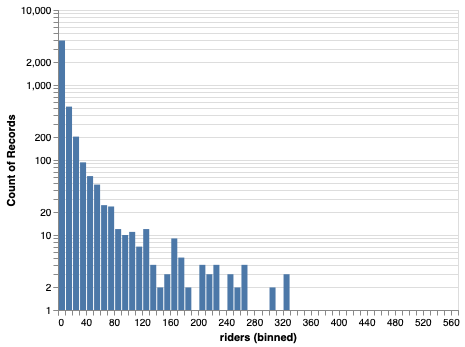

In [277]:
alt.Chart(df.sample(5000)).mark_bar().encode(
    x=alt.X("riders", bin=alt.Bin(maxbins=100)),
    y=alt.Y("count()", scale=alt.Scale(type="log")),
)

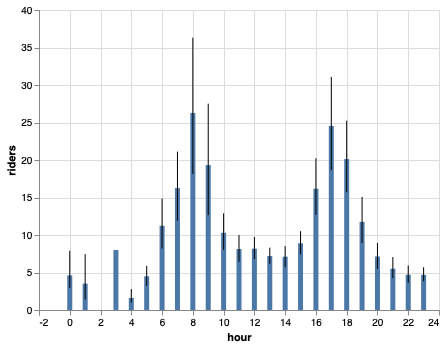

In [278]:
# TODO: this chart is highly sensitive to down-sampling. Probably due to days where special events were being held
# causing the 2am bar to change
bars = alt.Chart().mark_bar().encode(x="hour", y="mean(riders)")

error_bars = alt.Chart().mark_errorbar(extent="ci").encode(x="hour", y="riders")

alt.layer(bars, error_bars, data=df.sample(5000))

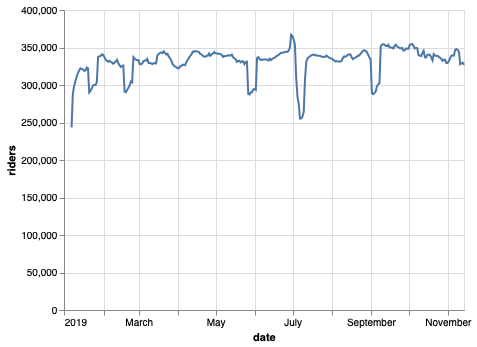

In [279]:
ser = pd.DataFrame(
    pd.Series(df.groupby("date").apply(lambda x: x.riders.sum()))
    .rolling(window=7)
    .mean()
).reset_index()
ser.columns = ["date", "riders"]

alt.Chart(ser).mark_line().encode(x="date:T", y="riders")

In [280]:
totaled = pd.DataFrame(
    df.groupby(["start", "stop"]).apply(lambda x: sum(x.riders))
).reset_index()
totaled.columns = ["start", "stop", "rides"]

In [281]:
totaled.head()

,start,stop,rides
0,12TH,12TH,16656
1,12TH,16TH,86846
2,12TH,19TH,16669
3,12TH,24TH,72346
4,12TH,ANTC,42513


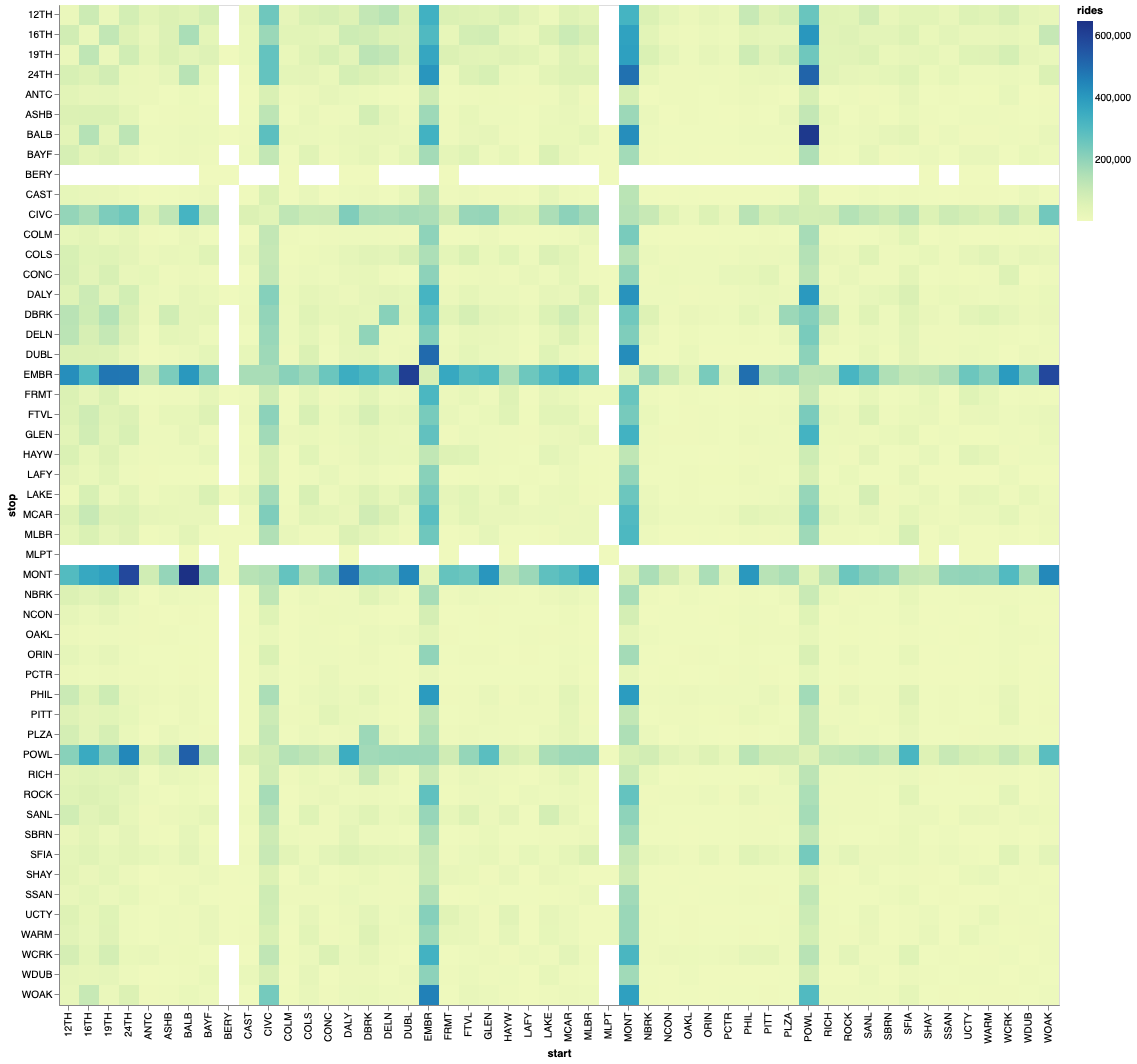

In [282]:
alt.Chart(totaled).mark_rect().encode(
    x="start:O",
    y="stop:O",
    color=alt.Color("rides"),
    tooltip=["start", "stop", "rides"],
)

# Fare Analysis

In [285]:
def get_fare(origin, destination):
    """
    Fetch fare information from the official BART API (http://api.bart.gov/docs/overview/examples.aspx)
    """
    r = requests.get(
        f"http://api.bart.gov/api/sched.aspx?cmd=fare&orig={origin}&dest={destination}&key=MW9S-E7SL-26DU-VV8V&json=y"
    )
    try:
        dat = r.json()
    except json.decoder.JSONDecodeError:
        return None
    else:
        return float([f for f in dat["root"]["fares"]["fare"] if f["@name"] == "Clipper"][0]['@amount'])


get_fare("RICH", "PLZA")

2.0

In [286]:
bart_fares = pd.DataFrame(
    [
        {"start": origin, "stop": destination, "fare": get_fare(origin, destination),}
        for origin, destination in list(itertools.product(stations, stations))
    ]
)

In [301]:
bart_fares.head()

,start,stop,fare,savings
0,PLZA,PLZA,5.90,1.681909
1,PLZA,PHIL,4.00,-0.218091
2,PLZA,DELN,2.00,-2.218091
3,PLZA,NBRK,2.00,-2.218091
4,PLZA,PITT,5.15,0.931909


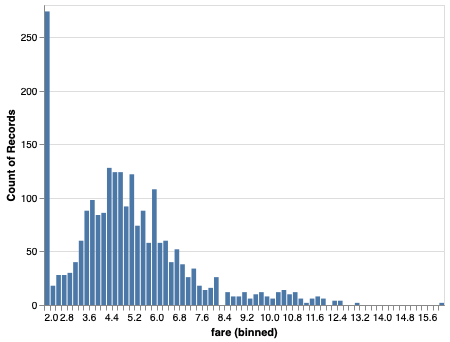

In [289]:
alt.Chart(
    bart_fares
).mark_bar().encode(
    x=alt.X('fare', bin=alt.Bin(maxbins=100)),
    y='count()'
)

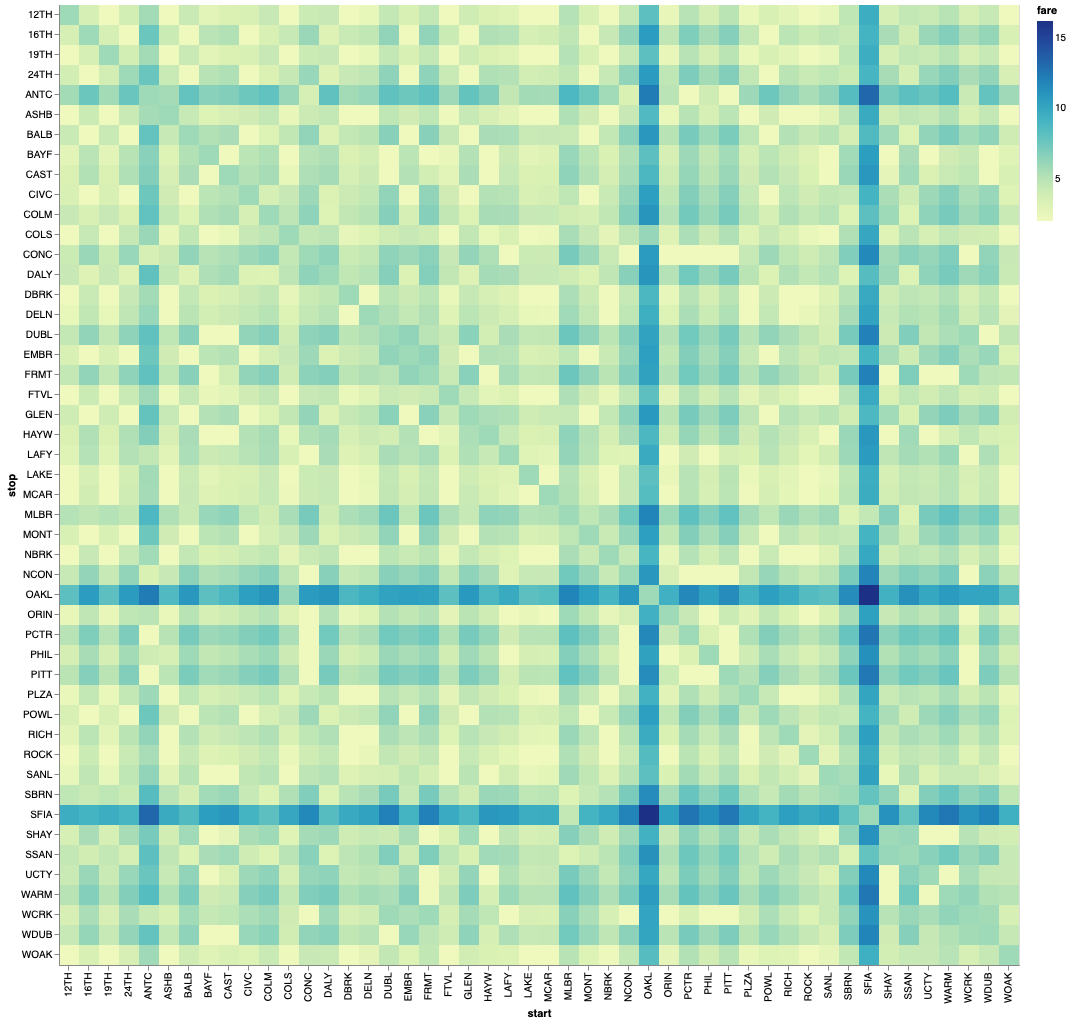

In [302]:
alt.Chart(bart_fares).mark_rect().encode(
    x="start:O", y="stop:O", color=alt.Color("fare"), tooltip=["start", "stop", "fare"],
)

In [303]:
bart_fares_rides = bart_fares.merge(totaled, on=["start", "stop"])
bart_fares_rides["revenue"] = bart_fares_rides["fare"] * bart_fares_rides["rides"]
bart_fares_rides.head()

,start,stop,fare,savings,rides,revenue
0,PLZA,PLZA,5.90,1.681909,4912,28980.8
1,PLZA,PHIL,4.00,-0.218091,4750,19000.0
2,PLZA,DELN,2.00,-2.218091,22078,44156.0
3,PLZA,NBRK,2.00,-2.218091,14128,28256.0
4,PLZA,PITT,5.15,0.931909,1866,9609.9


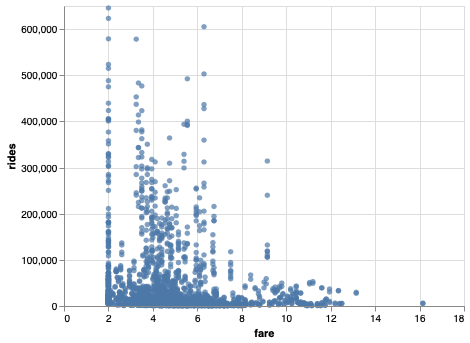

In [304]:
alt.Chart(bart_fares_rides).mark_circle().encode(
    x="fare", y="rides", tooltip=["start", "stop", "fare", "rides"],
)

In [305]:
df_revenue = df.merge(bart_fares, on=['start', 'stop'])
df_revenue['revenue'] = df_revenue['riders'] * df_revenue['fare']
df_revenue.head()

,date,hour,start,stop,riders,fare,savings,revenue
0,2019-01-01,0,12TH,12TH,3,5.9,1.681909,17.7
1,2019-01-01,1,12TH,12TH,1,5.9,1.681909,5.9
2,2019-01-01,10,12TH,12TH,1,5.9,1.681909,5.9
3,2019-01-01,11,12TH,12TH,1,5.9,1.681909,5.9
4,2019-01-01,12,12TH,12TH,2,5.9,1.681909,11.8


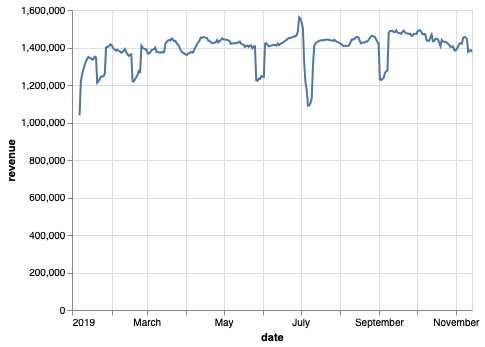

In [306]:
ser = pd.DataFrame(
    pd.Series(df_revenue.groupby("date").apply(lambda x: x.revenue.sum()))
    .rolling(window=7)
    .mean()
).reset_index()
ser.columns = ["date", "revenue"]

alt.Chart(ser).mark_line().encode(x="date:T", y="revenue")

In [307]:
"%i" % df_revenue["revenue"].sum()  # does this match up with any public data ??

'444130684'

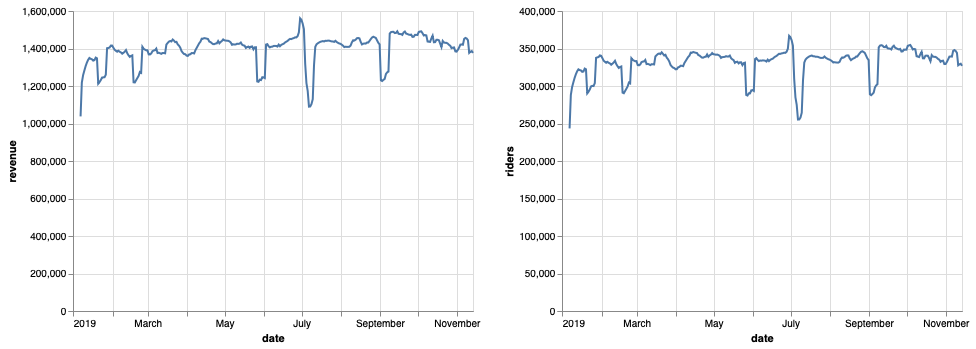

In [308]:
ser_revenue = pd.DataFrame(
    pd.Series(df_revenue.groupby("date").apply(lambda x: x.revenue.sum()))
    .rolling(window=7)
    .mean()
).reset_index()
ser_revenue.columns = ["date", "revenue"]

c1 = alt.Chart(ser_revenue).mark_line().encode(x="date:T", y="revenue")

ser_riders = pd.DataFrame(
    pd.Series(df_revenue.groupby("date").apply(lambda x: x.riders.sum()))
    .rolling(window=7)
    .mean()
).reset_index()
ser_riders.columns = ["date", "riders"]

c2 = alt.Chart(ser_riders).mark_line().encode(x="date:T", y="riders")

c1 | c2

In [309]:
# what would the flat rate be?
flat_rate = df_revenue["revenue"].sum() / df_revenue["riders"].sum()
"trip flat rate: %.2f" % flat_rate

'trip flat rate: 4.22'

In [310]:
"monthly flat rate: %.2f" % (flat_rate * 30)

'monthly flat rate: 126.54'

# bart fare savings by trip

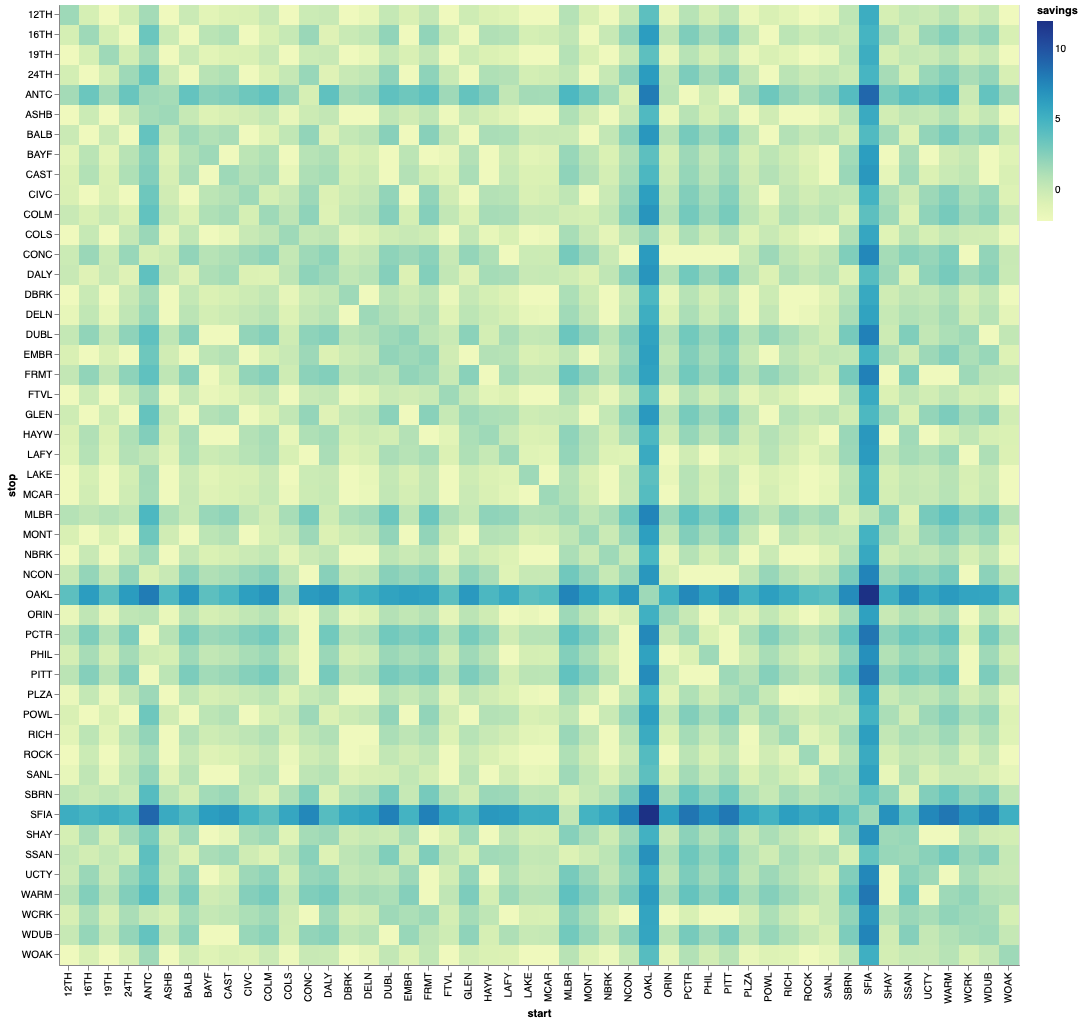

In [311]:
bart_fares["savings"] = bart_fares["fare"] - flat_rate
alt.Chart(bart_fares).mark_rect().encode(
    x="start:O",
    y="stop:O",
    color=alt.Color("savings"),
    tooltip=["start", "stop", "fare", "savings"],
)

In [317]:
bart_fares.sort_values(by="fare", ascending=False)

,start,stop,fare,savings
1242,OAKL,SFIA,16.15,11.931909
2124,SFIA,OAKL,16.15,11.931909
2105,SFIA,ANTC,13.15,8.931909
292,ANTC,SFIA,13.15,8.931909
2092,PCTR,SFIA,12.50,8.281909
...,...,...,...,...
2390,WARM,BERY,NaN,NaN
2425,MCAR,MLPT,NaN,NaN
2440,MCAR,BERY,NaN,NaN
2475,POWL,MLPT,NaN,NaN
